In [1]:
# import anndata as an
import numpy as np
import pandas as pd
from scipy.spatial import distance
from scipy import stats
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KDTree
from sklearn.decomposition import PCA
from deside.utility import set_fig_style
from deside.utility.read_file import ReadH5AD
import matplotlib.pyplot as plt
import seaborn as sns
set_fig_style(font_family='Arial', font_size=8)
import scanpy as sc
from matplotlib import rcParams

2023-03-14 22:29:40.846164: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 22:29:41.041899: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-14 22:29:41.624257: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-14 22:29:41.624349: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

In [2]:
merged_sc_ds = ReadH5AD('../datasets/single_cell/merged_7_sc_datasets_log2cpm1p.h5ad').get_h5ad()
merged_sc_ds

AnnData object with n_obs × n_vars = 135049 × 12114
    obs: 'sample_id', 'leiden_1st', 'dataset_id', 'cell_type', 'hit_cell_type', 'm_max_cd4/mean_cd8', 'm_cd4/m_cd8 group', 'leiden', 'label', 'cancer_type', 'subgroup_id'
    var: 'gene_ids'
    uns: 'dataset_id_colors', 'dendrogram_leiden', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'unique_exp_values'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [3]:
merged_sc_ds_info = merged_sc_ds.obs.copy()
merged_sc_ds_info.head(2)

,sample_id,leiden_1st,dataset_id,cell_type,hit_cell_type,m_max_cd4/mean_cd8,m_cd4/m_cd8 group,leiden,label,cancer_type,subgroup_id
AAACCTGTCTTCGAGA-1_HNSCC_1_TIL-0-0-0-0-0-0,HNSCC_1_TIL,Neu / Mac,hnscc_cillo_01,Macrophages,Macrophages,2.0,high,Macrophages (2),Macrophages (2)-Neu / Mac-hnscc_cillo_01,HNSCC,hnscc_cillo_01_HNSCC_Macrophages
AAAGATGAGCTAGTCT-1_HNSCC_1_TIL-0-0-0-0-0-0,HNSCC_1_TIL,Macrophages,hnscc_cillo_01,Macrophages,Macrophages,2.0,high,Macrophages (1),Macrophages (1)-Macrophages-hnscc_cillo_01,HNSCC,hnscc_cillo_01_HNSCC_Macrophages


In [4]:
merged_sc_ds_info['dataset_id'].unique()

['hnscc_cillo_01', 'pdac_pengj_02', 'hnscc_puram_03', 'pdac_steele_04', 'luad_kim_05', 'nsclc_guo_06', 'pan_cancer_07']
Categories (7, object): ['hnscc_cillo_01', 'pdac_pengj_02', 'hnscc_puram_03', 'pdac_steele_04', 'luad_kim_05', 'nsclc_guo_06', 'pan_cancer_07']

In [5]:
# merged_sc_exp = ReadH5AD('../datasets/single_cell/merged_7_sc_datasets_log2cpm1p.h5ad').get_df(convert_to_tpm=True)
merged_sc_exp = ReadH5AD('../datasets/single_cell/merged_7_sc_datasets_log2cpm1p.h5ad').get_df(convert_to_tpm=False)
print(merged_sc_exp.shape)
merged_sc_exp.head(2)

(135049, 12114)


,A1BG,A2M,A4GALT,AAAS,AACS,AAED1,AAGAB,AAK1,AAMDC,AAMP,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
AAACCTGTCTTCGAGA-1_HNSCC_1_TIL-0-0-0-0-0-0,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.527,7.527,0.000
AAAGATGAGCTAGTCT-1_HNSCC_1_TIL-0-0-0-0-0-0,6.898,0.0,0.0,0.0,0.0,6.898,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,6.898


### Multiple datasets (seperated)

#### hnscc_cillo_01, pdac_pengj_02, luad_kim_05, pan_cancer_07

In [6]:
def get_tsne_value_multiple_datasets(merged_sc_exp, dataset_id:tuple, cell_types:tuple, merged_sc_info:pd.DataFrame, 
                                     perplexity:tuple = (30, 30), eps:tuple = (5, 5), n_max:tuple = (500, 3000), lr=100):
    print(f'Current dataset: {dataset_id}')
    non_cc = [i for i in cell_types if i != 'Cancer Cells']
    sc_exp_cc_list = []
    sc_exp_non_cc_list = []
    
    for ds in dataset_id:
        current_set = merged_sc_ds_info.loc[(merged_sc_ds_info['dataset_id'] == ds) & (merged_sc_ds_info['cell_type'].isin(cell_types)), :]
        for cell_type, g in current_set.groupby('cell_type'):
            _n_max = n_max[0]
            if cell_type == 'Cancer Cells':
                _n_max = n_max[1]
            if g.shape[0] > _n_max:
                g = g.sample(_n_max, random_state=0)
            selected_samples = merged_sc_exp.loc[g.index, :].copy()
            if cell_type == 'Cancer Cells':
                sc_exp_cc_list.append(selected_samples)
            else:
                sc_exp_non_cc_list.append(selected_samples)

    sc_exp_cc = pd.concat(sc_exp_cc_list)
    sc_exp_non_cc = pd.concat(sc_exp_non_cc_list)

    print(f'The shape of cancer cells: {sc_exp_cc.shape}, the shape of non-cancer cells: {sc_exp_non_cc.shape}')
    x_embedded_cc = TSNE(n_components=2, perplexity=perplexity[0], learning_rate=lr).fit_transform(sc_exp_cc.values)
    x_embedded_non_cc = TSNE(n_components=2, perplexity=perplexity[1], learning_rate=lr).fit_transform(sc_exp_non_cc.values)
    
    x_embedded_cc_df = pd.DataFrame(x_embedded_cc, index=sc_exp_cc.index, columns=['tSNE1', 'tSNE2'])
    x_embedded_non_cc_df = pd.DataFrame(x_embedded_non_cc, index=sc_exp_non_cc.index, columns=['tSNE1', 'tSNE2'])
    
    # annotation
    inx2sample = merged_sc_info['sample_id'].to_dict()
    inx2cell_type = merged_sc_info['cell_type'].to_dict()
    inx2dataset_id = merged_sc_ds_info['dataset_id'].to_dict()
    
    # clustering and removing outliers
    clustering_cc = DBSCAN(eps=eps[0], min_samples=30).fit(x_embedded_cc_df[['tSNE1', 'tSNE2']].values)
    print(f'Unique clustering labels of CC: {np.unique(clustering_cc.labels_)}')
    
    clustering_non_cc = DBSCAN(eps=eps[1], min_samples=30).fit(x_embedded_non_cc_df[['tSNE1', 'tSNE2']].values)
    print(f'Unique clustering labels of non-CC: {np.unique(clustering_non_cc.labels_)}')
    
    x_embedded_cc_df['label'] = clustering_cc.labels_
    x_embedded_non_cc_df['label'] = clustering_non_cc.labels_
    for _df in [x_embedded_cc_df, x_embedded_non_cc_df]:
        _df['sample_id'] = _df.index.map(inx2sample)
        _df['cell_type'] = _df.index.map(inx2cell_type)
        _df['dataset_id'] = _df.index.map(inx2dataset_id)

    
    # plot
    fig, axes = plt.subplots(ncols=2, figsize=(5, 2.5))
    g1 = sns.scatterplot(data=x_embedded_cc_df, x='tSNE1', y='tSNE2', hue='label', s=1, ax=axes[0])
    g1.set_title(f'Cancer cells')
    g2 = sns.scatterplot(data=x_embedded_non_cc_df, x='tSNE1', y='tSNE2', hue='label', s=1, ax=axes[1])
    g2.set_title(f'Non-cancer cells')
    plt.tight_layout()
    return x_embedded_cc_df, x_embedded_non_cc_df

In [7]:
merged_sc_exp.shape

(135049, 12114)

Current dataset: ('hnscc_cillo_01', 'pdac_pengj_02', 'luad_kim_05', 'pan_cancer_07')
The shape of cancer cells: (9000, 12114), the shape of non-cancer cells: (9602, 12114)
Unique clustering labels of CC: [0]
Unique clustering labels of non-CC: [-1  0  1]


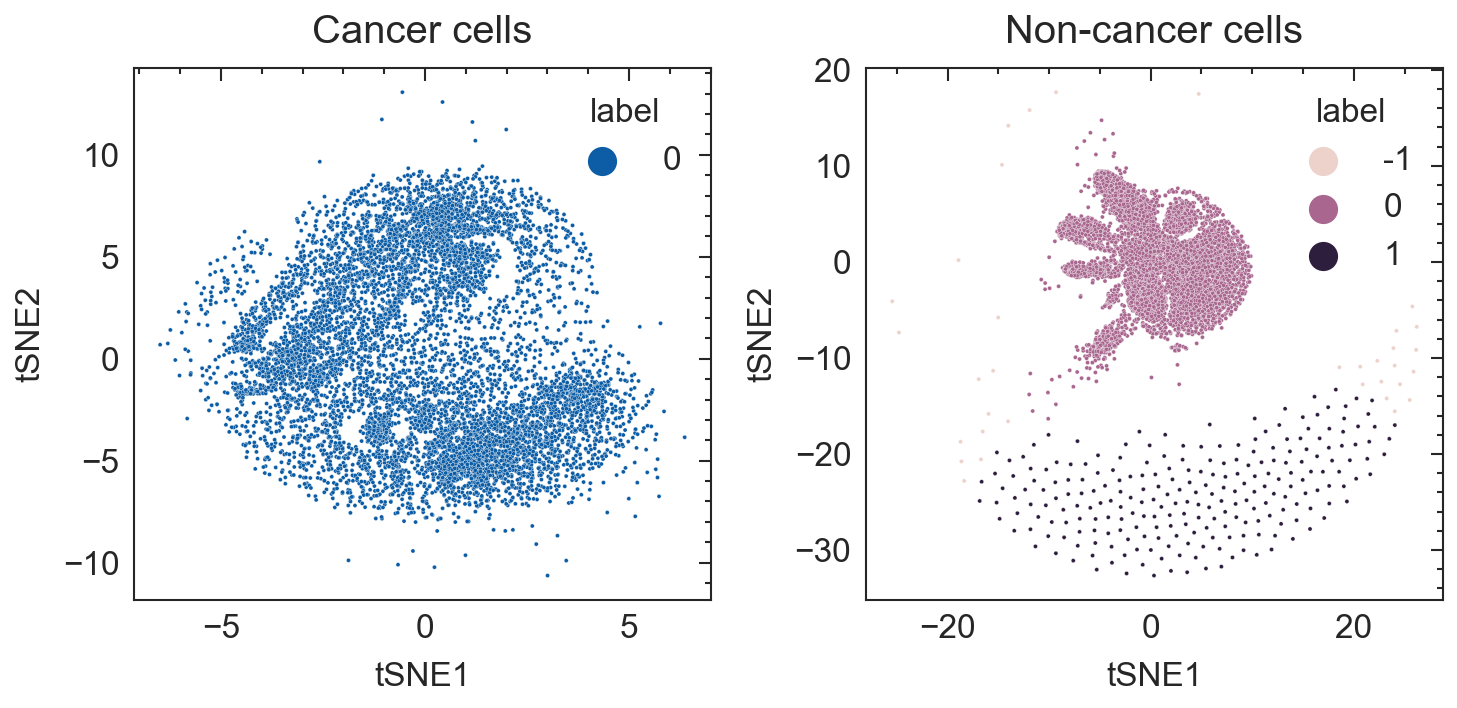

In [8]:
dataset_id = ('hnscc_cillo_01', 'pdac_pengj_02', 'luad_kim_05', 'pan_cancer_07')
x_embedded_1257_cc_df, x_embedded_1257_non_cc_df = \
    get_tsne_value_multiple_datasets(merged_sc_exp=merged_sc_exp, dataset_id=dataset_id, 
                                     merged_sc_info=merged_sc_ds_info, perplexity=(1000, 300), lr=50,
                                     cell_types=('B Cells', 'CD4 T', 'CD8 T', 'Endothelial Cells', 'Fibroblasts', 'Macrophages', 'NK', 'Cancer Cells', 'DC', 'Mast Cells'))

In [9]:
x_embedded_1257_cc_df2 = x_embedded_1257_cc_df.loc[x_embedded_1257_cc_df['label'] == 0, :].copy()
# x_embedded_1257_cc_df2['tSNE1'] = x_embedded_1257_cc_df2['tSNE1'] / x_embedded_max.max()
# x_embedded_1257_cc_df2['tSNE2'] = x_embedded_1257_cc_df2['tSNE2'] / x_embedded_max.max()

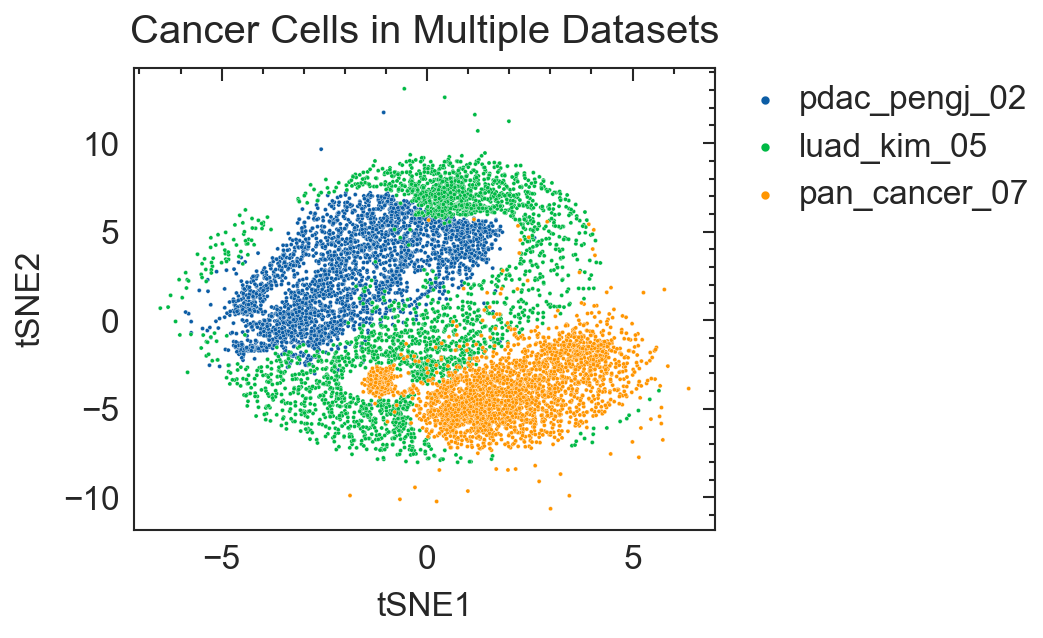

In [10]:
# sns.scatterplot(data=x_embedded.loc[x_embedded['cell_type'] != 'Cancer Cells'], x='tSNE1', y='tSNE2', hue='dataset_id', s=1)
plt.figure(figsize=(2.5, 2))
g = sns.scatterplot(data=x_embedded_1257_cc_df2, x='tSNE1', y='tSNE2', hue='dataset_id', s=1)
g2legend = g.legend()
for _ in g2legend.legendHandles:
    _.set_sizes([1])
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1), ncol=1, title=None, frameon=False, fontsize=8, borderpad=0, handletextpad=0)
plt.title('Cancer Cells in Multiple Datasets')
# plt.legend(loc='upper left', bbox_to_anchor=(1., 1), ncol=1, fontsize=8)
plt.savefig('3ds_cancer_cells_t-SNE.png', dpi=300)

In [11]:
x_embedded_1257_non_cc_df2 = x_embedded_1257_non_cc_df.loc[x_embedded_1257_non_cc_df['label'] == 0, :].copy()
# x_embedded_1257_non_cc_df2['tSNE1'] = x_embedded_1257_non_cc_df2['tSNE1'] / x_embedded_max2.max()
# x_embedded_1257_non_cc_df2['tSNE2'] = x_embedded_1257_non_cc_df2['tSNE2'] / x_embedded_max2.max()

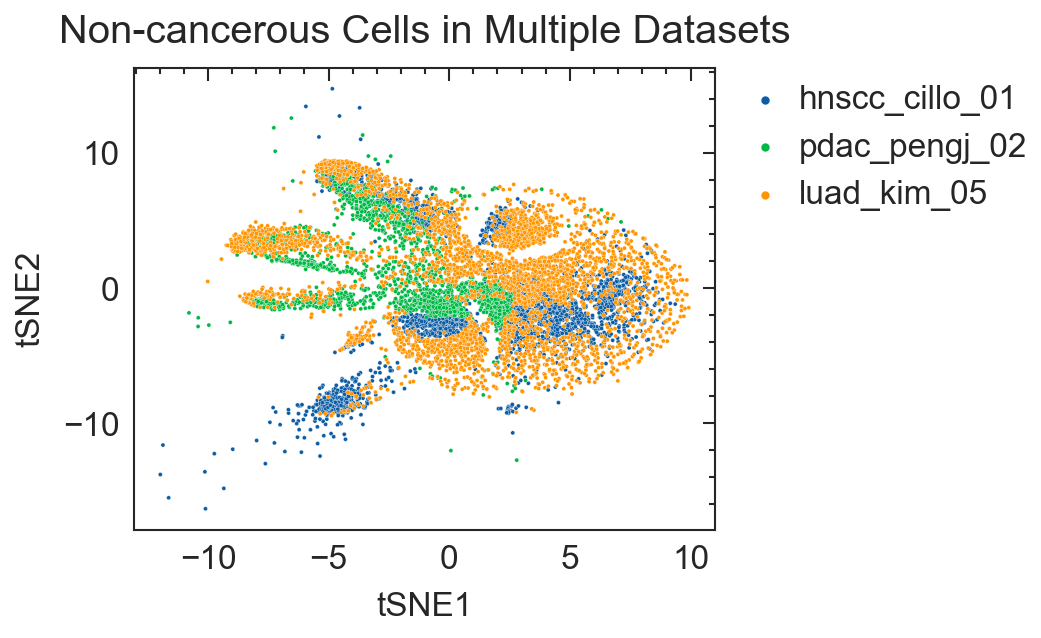

In [12]:
# sns.scatterplot(data=x_embedded.loc[x_embedded['cell_type'] != 'Cancer Cells'], x='tSNE1', y='tSNE2', hue='dataset_id', s=1)
plt.figure(figsize=(2.5, 2))
g = sns.scatterplot(data=x_embedded_1257_non_cc_df2, x='tSNE1', y='tSNE2', hue='dataset_id', s=1)
g2legend = g.legend()
for _ in g2legend.legendHandles:
    _.set_sizes([1])
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1), ncol=1, title=None, frameon=False, fontsize=8, borderpad=0, handletextpad=0)
plt.title('Non-cancerous Cells in Multiple Datasets')
# g.set_xticks([-10, 0, 10])
# plt.legend(loc='upper left', bbox_to_anchor=(1., 1), ncol=1, fontsize=8)
plt.savefig('3ds_non-cancer_cells_t-SNE.png', dpi=300)

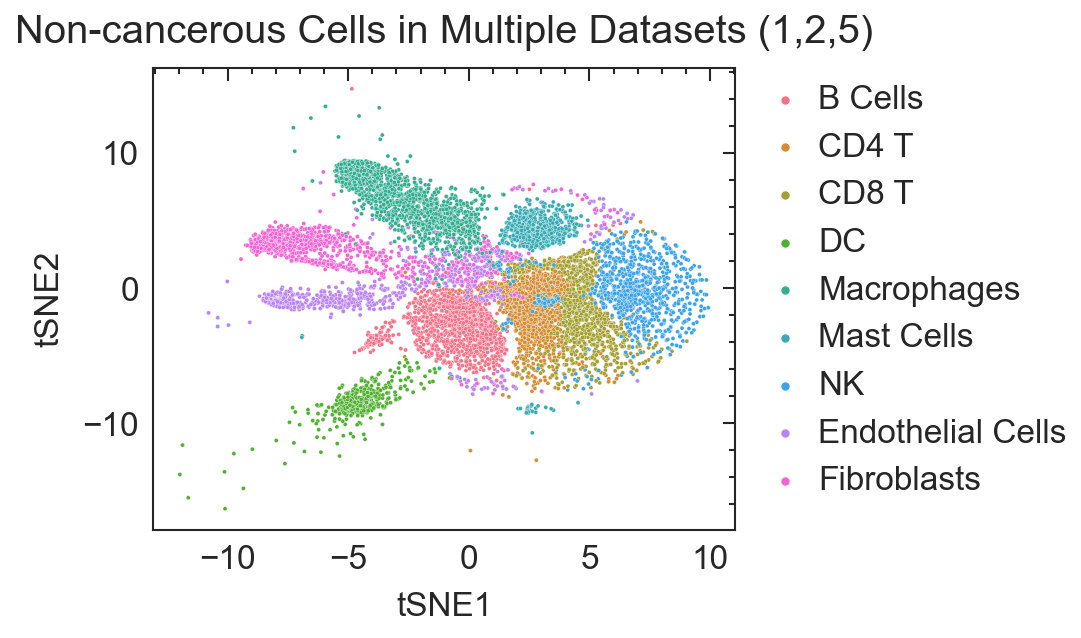

In [13]:
# sns.scatterplot(data=x_embedded.loc[x_embedded['cell_type'] != 'Cancer Cells'], x='tSNE1', y='tSNE2', hue='dataset_id', s=1)
plt.figure(figsize=(2.5, 2))
g = sns.scatterplot(data=x_embedded_1257_non_cc_df2, x='tSNE1', y='tSNE2', hue='cell_type', s=1)
g2legend = g.legend()
for _ in g2legend.legendHandles:
    _.set_sizes([1])
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1), ncol=1, title=None, frameon=False, fontsize=8, borderpad=0, handletextpad=0)
plt.title('Non-cancerous Cells in Multiple Datasets (1,2,5)')
# plt.legend(loc='upper left', bbox_to_anchor=(1., 1), ncol=1, fontsize=8)
plt.savefig('3ds_cancer_cells_t-SNE_cell_type.png', dpi=300)

#### Cancer cells and Non-cancerous cells across different patients

#### hnscc_puram_03

In [33]:
def get_tsne_values(merged_sc_exp, dataset_id, merged_sc_info, perplexity:tuple = (30, 30), eps:tuple = (5, 5), lr=100, sample_id=None):
    print(f'Current dataset: {dataset_id}')
    sc_exp_non_cc = merged_sc_exp.loc[(merged_sc_ds_info['dataset_id'] == dataset_id) &
                                         (merged_sc_ds_info['cell_type'] != 'Cancer Cells'), :].copy()
    sc_exp_cc = merged_sc_exp.loc[(merged_sc_ds_info['dataset_id'] == dataset_id) &
                                     (merged_sc_ds_info['cell_type'] == 'Cancer Cells'), :].copy()
    if sample_id:
        sc_exp_non_cc = sc_exp_non_cc.loc[merged_sc_info['sample_id'].isin(sample_id), :].copy()
        sc_exp_cc = sc_exp_cc.loc[merged_sc_info['sample_id'].isin(sample_id), :].copy()
    # if sc_exp_cc.shape[0] > sc_exp_non_cc.shape[0]:
    #     sc_exp_cc = sc_exp_cc.sample(sc_exp_non_cc.shape[0])
    # else:
    #     sc_exp_non_cc = sc_exp_non_cc.sample(sc_exp_cc.shape[0])

    print(f'The shape of cancer cells: {sc_exp_cc.shape}, the shape of non-cancer cells: {sc_exp_non_cc.shape}')
    x_embedded_cc = TSNE(n_components=2, perplexity=perplexity[0], learning_rate=lr).fit_transform(sc_exp_cc.values)
    x_embedded_non_cc = TSNE(n_components=2, perplexity=perplexity[1], learning_rate=lr).fit_transform(sc_exp_non_cc.values)
    
    x_embedded_cc_df = pd.DataFrame(x_embedded_cc, index=sc_exp_cc.index, columns=['tSNE1', 'tSNE2'])
    x_embedded_non_cc_df = pd.DataFrame(x_embedded_non_cc, index=sc_exp_non_cc.index, columns=['tSNE1', 'tSNE2'])
    
    # annotation
    inx2sample = merged_sc_info['sample_id'].to_dict()
    inx2cell_type = merged_sc_info['cell_type'].to_dict()
    
    # clustering and removing outliers
    clustering_cc = DBSCAN(eps=eps[0], min_samples=30).fit(x_embedded_cc_df[['tSNE1', 'tSNE2']].values)
    print(f'Unique clustering labels of CC: {np.unique(clustering_cc.labels_)}')
    
    clustering_non_cc = DBSCAN(eps=eps[1], min_samples=30).fit(x_embedded_non_cc_df[['tSNE1', 'tSNE2']].values)
    print(f'Unique clustering labels of non-CC: {np.unique(clustering_non_cc.labels_)}')
    
    x_embedded_cc_df['label'] = clustering_cc.labels_
    x_embedded_non_cc_df['label'] = clustering_non_cc.labels_
    for _df in [x_embedded_cc_df, x_embedded_non_cc_df]:
        _df['sample_id'] = _df.index.map(inx2sample)
        _df['cell_type'] = _df.index.map(inx2cell_type)

    
    # plot
    fig, axes = plt.subplots(ncols=2, figsize=(5, 2.5))
    g1 = sns.scatterplot(data=x_embedded_cc_df, x='tSNE1', y='tSNE2', hue='label', s=1, ax=axes[0])
    g1.set_title(f'Cancer cells')
    g2 = sns.scatterplot(data=x_embedded_non_cc_df, x='tSNE1', y='tSNE2', hue='label', s=1, ax=axes[1])
    g2.set_title(f'Non-cancer cells')
    plt.tight_layout()
    return x_embedded_cc_df, x_embedded_non_cc_df

Current dataset: hnscc_puram_03
The shape of cancer cells: (1541, 12114), the shape of non-cancer cells: (1479, 12114)
Unique clustering labels of CC: [-1  0]
Unique clustering labels of non-CC: [-1  0  1]


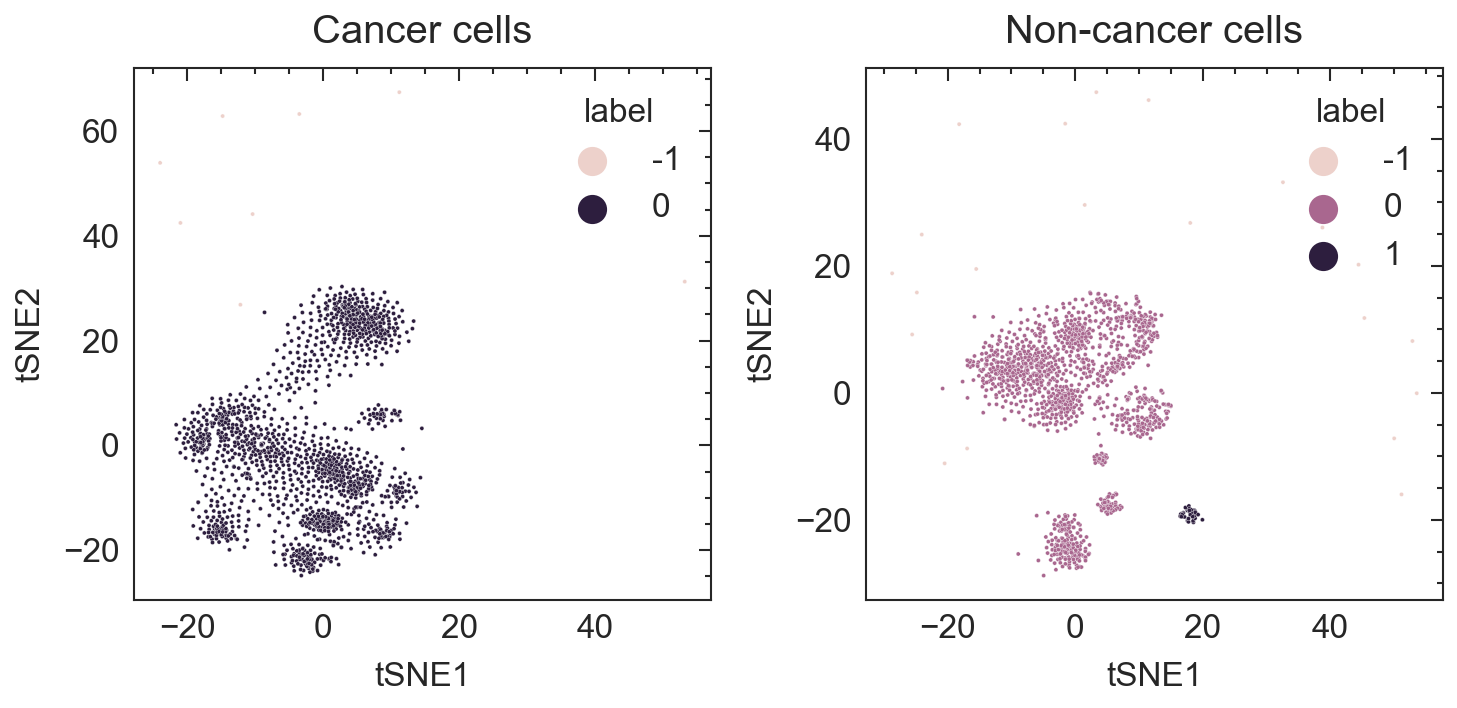

In [34]:
dataset_id = 'hnscc_puram_03'
sample_id = ['HN5', 'HN6', 'HN16', 'HN17', 'HN18', 'HN20', 'HN22', 'HN25', 'HN26', 'HN28']
x_embedded_03_cc_df, x_embedded_03_non_cc_df = get_tsne_values(merged_sc_exp=merged_sc_exp, dataset_id=dataset_id, 
                                                               merged_sc_info=merged_sc_ds_info, perplexity=(50, 50), lr=50, sample_id=sample_id)

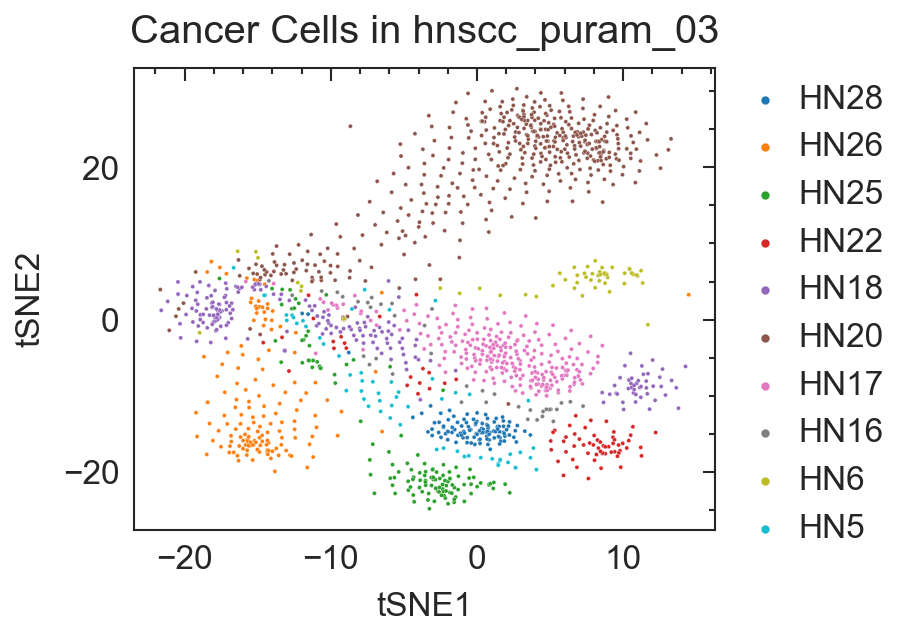

In [42]:
# sns.scatterplot(data=x_embedded.loc[x_embedded['cell_type'] != 'Cancer Cells'], x='tSNE1', y='tSNE2', hue='dataset_id', s=1)
plt.figure(figsize=(2.5, 2))
g = sns.scatterplot(data=x_embedded_03_cc_df.loc[x_embedded_03_cc_df['label'] == 0], x='tSNE1', y='tSNE2', hue='sample_id', s=1, rasterized=True, palette='tab10')
g2legend = g.legend()
for _ in g2legend.legendHandles:
    _.set_sizes([1])
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1), ncol=1, title=None, frameon=False, fontsize=8, borderpad=0, handletextpad=0)
plt.title('Cancer Cells in hnscc_puram_03')
# plt.legend(loc='upper left', bbox_to_anchor=(1., 1), ncol=1, fontsize=8)
plt.savefig('03_cancer_cells_t-SNE.svg', dpi=300)

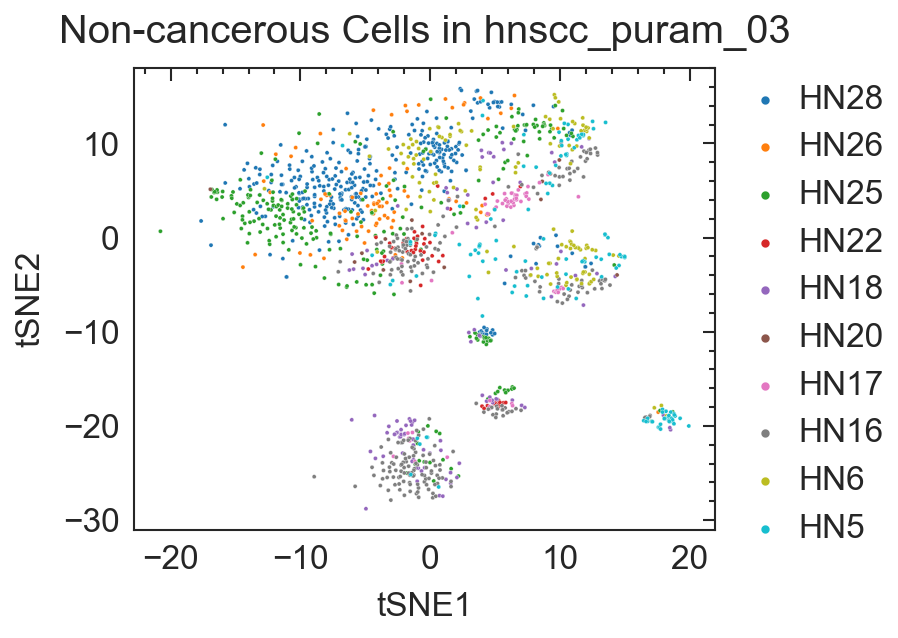

In [43]:
# sns.scatterplot(data=x_embedded.loc[x_embedded['cell_type'] != 'Cancer Cells'], x='tSNE1', y='tSNE2', hue='dataset_id', s=1)
plt.figure(figsize=(2.5, 2))
g = sns.scatterplot(data=x_embedded_03_non_cc_df.loc[x_embedded_03_non_cc_df['label'] != -1], x='tSNE1', y='tSNE2', hue='sample_id', s=1, rasterized=True, palette='tab10')
g2legend = g.legend()
for _ in g2legend.legendHandles:
    _.set_sizes([1])
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1), ncol=1, title=None, frameon=False, fontsize=8, borderpad=0, handletextpad=0)
plt.title('Non-cancerous Cells in hnscc_puram_03')
# plt.legend(loc='upper left', bbox_to_anchor=(1., 1), ncol=1, fontsize=8)
plt.savefig('03_non-cancer_cells_t-SNE.svg', dpi=300)

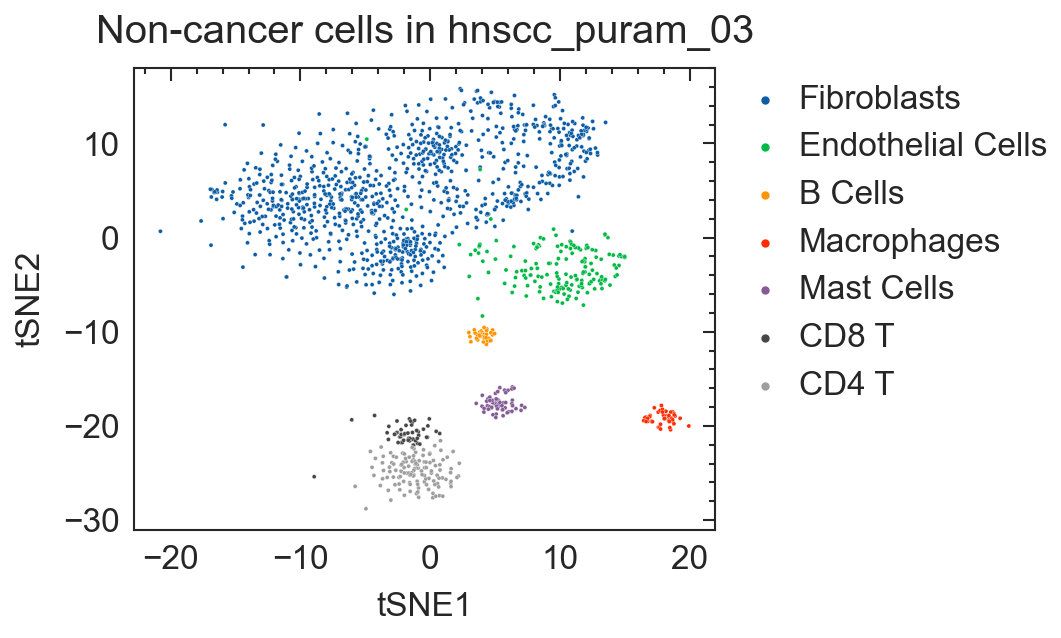

In [44]:
# sns.scatterplot(data=x_embedded.loc[x_embedded['cell_type'] != 'Cancer Cells'], x='tSNE1', y='tSNE2', hue='dataset_id', s=1)
plt.figure(figsize=(2.5, 2))
g = sns.scatterplot(data=x_embedded_03_non_cc_df.loc[x_embedded_03_non_cc_df['label'] != -1], x='tSNE1', y='tSNE2', hue='cell_type', s=1, rasterized=True)
g2legend = g.legend()
for _ in g2legend.legendHandles:
    _.set_sizes([1])
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1), ncol=1, title=None, frameon=False, fontsize=8, borderpad=0, handletextpad=0)
plt.title('Non-cancer cells in hnscc_puram_03')
# plt.legend(loc='upper left', bbox_to_anchor=(1., 1), ncol=1, fontsize=8)
plt.savefig('03_non-cancer_cells_t-SNE_cell_type.svg', dpi=300)

In [45]:
x_embedded_03_cc_df.loc[x_embedded_03_cc_df['label'] == 0].shape

(1533, 5)

In [46]:
x_embedded_03_non_cc_df.loc[x_embedded_03_non_cc_df['label'] == 0].shape

(1410, 5)